## Set Up and mini EDA

In [93]:
import numpy as np
import pandas as pd
import datetime as dt
from pandas_datareader import data as pdr
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.optimize import minimize

sns.set()

stocks = pd.read_csv('adjprice.csv')


In [95]:
stocks.set_index(pd.to_datetime(stocks["Date"], format='%Y%m%d'), inplace=True)
stocks.drop(columns=["Date"], inplace=True)
stocks.shape


(9459, 1199)

In [9]:
# Specify the date range you want to filter (you can modify this easily)
start_year = '1997'
end_year = '1997'

# Step 1: Filter the data by date range
totalreturns = stocks.pct_change(fill_method = None)

# Filter the data for the selected date range (adjustable)
returns = totalreturns.loc[start_year:end_year].copy()

#Drop rows with NaN values (clean data)
returns.dropna(axis = 1, how = 'any', inplace=True) #must be axis 1! na in columns 

In [10]:
# Check the number of NaN values in the DataFrame
print(returns.isna().sum())

0111145D US Equity    0
0202445Q US Equity    0
0203524D US Equity    0
0226226D US Equity    0
0376152D US Equity    0
                     ..
XTO US Equity         0
YRCW US Equity        0
ZETHQ US Equity       0
ZION US Equity        0
ZRN US Equity         0
Length: 855, dtype: int64


In [11]:
# Compare mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()
n_assets = len(mean_returns)


# Portfolio statistics functions
def portfolio_stats(weights, mean_returns, cov_matrix):
    port_return = np.dot(weights, mean_returns)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return port_return, port_volatility

# Optimization function to minimize volatility
def min_volatility(weights):
    return portfolio_stats(weights, mean_returns, cov_matrix)[1]

returns.shape

(365, 855)

# Random EDA (July 31 2019)

Please note that Abbey is silly, forgot that this was the final day of data within the set so there is no change in data, should be dropped for working dataset

In [14]:
july31 = totalreturns[totalreturns.index == pd.Timestamp('2019-07-31')].dropna(axis = 1)
july31.sum()

A US Equity       0.0
AA US Equity      0.0
AAL US Equity     0.0
AAP US Equity     0.0
AAPL US Equity    0.0
                 ... 
YUM US Equity     0.0
YUMC US Equity    0.0
ZBH US Equity     0.0
ZION US Equity    0.0
ZTS US Equity     0.0
Length: 670, dtype: float64

mean variance is more diversified becuase it focuses on lower variance # more diversified 

# FIND SYMBOLS & SECTORS OF CURRENT S&P 500 STOCKS

In [17]:
# !pip install yfinance
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [208]:
# Fetch and parse HTML
html_data = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies').text
beautiful_soup = BeautifulSoup(html_data, "html.parser")
tables = beautiful_soup.find_all('table')

# Prepare a list to store row data
company_data = []

# Loop through table rows
for row in tables[0].tbody.find_all("tr"):
    cols = row.find_all("td")
    if cols:
        company_info = {
            "Symbol": cols[0].text.strip(),
            "Sector": cols[2].text.strip(),
            "Sub-Industry": cols[3].text.strip()
        }
        company_data.append(company_info)

# Convert to DataFrame
S_P_500_companies = pd.DataFrame(company_data)

S_P_500_companies

# FOR DATAFRAME WITH JUST SYMBOLS Prepare a list to store row data
company_symbols = []

# Loop through table rows
for row in tables[0].tbody.find_all("tr"):
    cols = row.find_all("td")
    if cols:
        company_info = {
            "Symbol": cols[0].text.strip(),
        }
        company_symbols.append(company_info)

# Convert to DataFrame
S_P_500_symbols = pd.DataFrame(company_symbols)

S_P_500_companies

,Symbol,Sector,Sub-Industry
0,MMM,Industrials,Industrial Conglomerates
1,AOS,Industrials,Building Products
2,ABT,Health Care,Health Care Equipment
3,ABBV,Health Care,Biotechnology
4,ACN,Information Technology,IT Consulting & Other Services
...,...,...,...
498,XYL,Industrials,Industrial Machinery & Supplies & Components
499,YUM,Consumer Discretionary,Restaurants
500,ZBRA,Information Technology,Electronic Equipment & Instruments
501,ZBH,Health Care,Health Care Equipment


In [206]:
newreturns = totalreturns.loc['2014':'2019'].copy()

# Add a column to match the Bloomberg-style label
S_P_500_companies["Ticker Label"] = S_P_500_companies["Symbol"] + " US Equity"

# Transpose returns so tickers become rows (index)
returns_T = newreturns.T  # shape: (tickers, dates)
returns_T.dropna(inplace = True)

# Merge on index with S&P 500 company data
returns_with_sector = returns_T.merge(S_P_500_companies, left_index=True, right_on='Ticker Label', how='inner')
returns_with_sector.set_index('Symbol', inplace=True)
returns_with_sector = returns_with_sector.drop('Ticker Label', axis = 1)
#Drop rows of dates representing weekends / market holidays 
returns_with_sector = returns_with_sector[(returns_with_sector != 0).any(axis=1)]

returns_with_sector



,2014-01-01 00:00:00,2014-01-02 00:00:00,2014-01-03 00:00:00,2014-01-04 00:00:00,2014-01-05 00:00:00,2014-01-06 00:00:00,2014-01-07 00:00:00,2014-01-08 00:00:00,2014-01-09 00:00:00,2014-01-10 00:00:00,...,2019-07-24 00:00:00,2019-07-25 00:00:00,2019-07-26 00:00:00,2019-07-27 00:00:00,2019-07-28 00:00:00,2019-07-29 00:00:00,2019-07-30 00:00:00,2019-07-31 00:00:00,Sector,Sub-Industry
Symbol,,,,,,,,,,,,,,,,,,,,,
A,0.0,-0.017135,0.012630,0.0,0.0,-0.004919,0.014301,0.016364,0.000341,0.008903,...,-0.004436,0.003880,-0.005011,0.0,0.0,0.012518,-0.003126,0.0,Health Care,Life Sciences Tools & Services
AAPL,0.0,-0.014063,-0.021966,0.0,0.0,0.005453,-0.007156,0.006338,-0.012772,-0.006671,...,-0.000814,-0.007907,0.003478,0.0,0.0,0.009339,-0.004292,0.0,Information Technology,"Technology Hardware, Storage & Peripherals"
ABBV,0.0,-0.015718,0.006156,0.0,0.0,-0.036519,0.001983,-0.002575,0.017077,-0.006247,...,-0.003986,-0.011859,0.016502,0.0,0.0,-0.008560,0.000000,0.0,Health Care,Biotechnology
ABT,0.0,-0.002610,0.010724,0.0,0.0,0.013199,-0.007663,0.009008,0.001787,0.007640,...,-0.001690,-0.006660,-0.002841,0.0,0.0,0.009117,-0.002710,0.0,Health Care,Health Care Equipment
ACN,0.0,-0.013257,0.003327,0.0,0.0,-0.010564,0.012167,0.007728,0.009739,0.003013,...,0.000051,0.002571,0.010053,0.0,0.0,0.002133,-0.008614,0.0,Information Technology,IT Consulting & Other Services
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XOM,0.0,-0.014328,-0.002406,0.0,0.0,0.001507,0.014148,-0.003265,-0.009728,0.007618,...,-0.000133,-0.005706,-0.001601,0.0,0.0,0.007085,0.000133,0.0,Energy,Integrated Oil & Gas
XYL,0.0,-0.012719,0.009076,0.0,0.0,-0.001740,0.002904,-0.000577,0.004058,0.008084,...,0.006848,-0.008137,-0.002326,0.0,0.0,-0.007241,0.002843,0.0,Industrials,Industrial Machinery & Supplies & Components
YUM,0.0,-0.006879,0.006260,0.0,0.0,-0.000794,0.014040,-0.000392,-0.019339,-0.000400,...,-0.002303,0.002042,0.010010,0.0,0.0,0.000702,-0.007537,0.0,Consumer Discretionary,Restaurants


In [20]:
#rename bc I'm lazy
rws = returns_with_sector

#group by sectors
grouped = rws.groupby('Sector')
print(f"There are {grouped['Sector'].nunique().sum()} unique sectors within the available dataset:")
print(grouped['Sector'].unique())

There are 11 unique sectors within the available dataset:
Sector
Communication Services    [Communication Services]
Consumer Discretionary    [Consumer Discretionary]
Consumer Staples                [Consumer Staples]
Energy                                    [Energy]
Financials                            [Financials]
Health Care                          [Health Care]
Industrials                          [Industrials]
Information Technology    [Information Technology]
Materials                              [Materials]
Real Estate                          [Real Estate]
Utilities                              [Utilities]
Name: Sector, dtype: object


In [21]:
tech = rws[rws['Sector'] == 'Information Technology'].drop(['Sector','Sub-Industry'], axis = 1).T

tech
corr = tech.select_dtypes('number').corr()
highcorr = corr[corr > 0.6]


In [22]:
tech.columns

Index(['AAPL', 'ACN', 'ADBE', 'ADI', 'ADSK', 'AKAM', 'AMAT', 'AMD', 'ANSS',
       'APH', 'AVGO', 'CDNS', 'CRM', 'CSCO', 'CTSH', 'FFIV', 'FSLR', 'GLW',
       'HPQ', 'IBM', 'INTC', 'INTU', 'IT', 'JBL', 'JNPR', 'KLAC', 'LRCX',
       'MCHP', 'MSFT', 'MSI', 'MU', 'NTAP', 'NVDA', 'ORCL', 'PTC', 'QCOM',
       'ROP', 'SNPS', 'STX', 'SWKS', 'TEL', 'TER', 'TXN', 'VRSN', 'WDC'],
      dtype='object', name='Symbol')

In [124]:
alldata = pd.read_csv('adjprice.csv')

# Convert Date column to datetime and set it as index
alldata['Date'] = pd.to_datetime(alldata['Date'], format='%Y%m%d')
alldata.set_index('Date', inplace=True)

# Now filter between 2014 and 2019 using the datetime index
from2014 = alldata.loc['2014':'2019'].copy()

#drop NA's axis = 1 to get stocks in S&P 500 during this time period
from2014.dropna(axis = 1, inplace = True)

# Add a column to match the Bloomberg-style label
S_P_500_symbols["Ticker Label"] = S_P_500_symbols["Symbol"] + " US Equity"
# Transpose returns so tickers become rows (index)
from2014 = from2014.T  # shape: (tickers, dates)
symbols2014 = from2014.merge(S_P_500_symbols, left_index=True, right_on='Ticker Label', how='inner')
symbols2014.set_index('Symbol', inplace=True)
symbols2014 = symbols2014.drop('Ticker Label', axis = 1)

# Convert index to datetime format
by_date.index = pd.to_datetime(symbols2014.T.copy().index)
by_date



Symbol,A,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,...,WMB,WMT,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZTS
2014-01-01,39.0305,73.2051,44.2816,34.3686,74.0534,59.879,45.1810,37.8597,63.5472,50.319,...,29.7256,69.4903,26.4598,172.8190,23.6883,85.0069,32.3069,49.3821,89.5687,31.4843
2014-01-02,38.3617,72.1756,43.5856,34.2789,73.0717,59.290,43.7173,37.5021,62.8087,49.250,...,29.5021,69.6846,26.2083,176.1381,23.3237,83.7889,31.8960,49.0424,88.6556,31.1665
2014-01-03,38.8462,70.5902,43.8539,34.6465,73.3148,59.160,44.0100,37.6765,63.4929,48.900,...,29.3094,69.4550,26.2670,174.4118,23.3152,83.5873,32.1855,49.3494,89.0401,30.8679
2014-01-04,38.8462,70.5902,43.8539,34.6465,73.3148,59.160,44.0100,37.6765,63.4929,48.900,...,29.3094,69.4550,26.2670,174.4118,23.3152,83.5873,32.1855,49.3494,89.0401,30.8679
2014-01-05,38.8462,70.5902,43.8539,34.6465,73.3148,59.160,44.0100,37.6765,63.4929,48.900,...,29.3094,69.4550,26.2670,174.4118,23.3152,83.5873,32.1855,49.3494,89.0401,30.8679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-27,69.5000,207.7400,67.7600,87.7500,196.9300,311.270,121.8000,40.5900,169.2700,167.990,...,25.1300,113.0200,26.2100,139.4300,60.5100,74.8100,81.4800,114.0200,134.5000,115.1100
2019-07-28,69.5000,207.7400,67.7600,87.7500,196.9300,311.270,121.8000,40.5900,169.2700,167.990,...,25.1300,113.0200,26.2100,139.4300,60.5100,74.8100,81.4800,114.0200,134.5000,115.1100
2019-07-29,70.3700,209.6800,67.1800,88.5500,197.3500,307.220,121.2100,40.9000,167.9100,162.770,...,24.7900,112.2700,25.8400,138.2700,60.9800,75.3400,80.8900,114.1000,134.5300,115.5500
2019-07-30,70.1500,208.7800,67.1800,88.3100,195.6500,303.640,120.9600,40.9500,165.0000,160.290,...,25.0200,112.0600,26.0900,135.6100,60.5900,75.3500,81.1200,113.2400,136.6700,115.7900


Text(0, 0.5, 'daily returns')

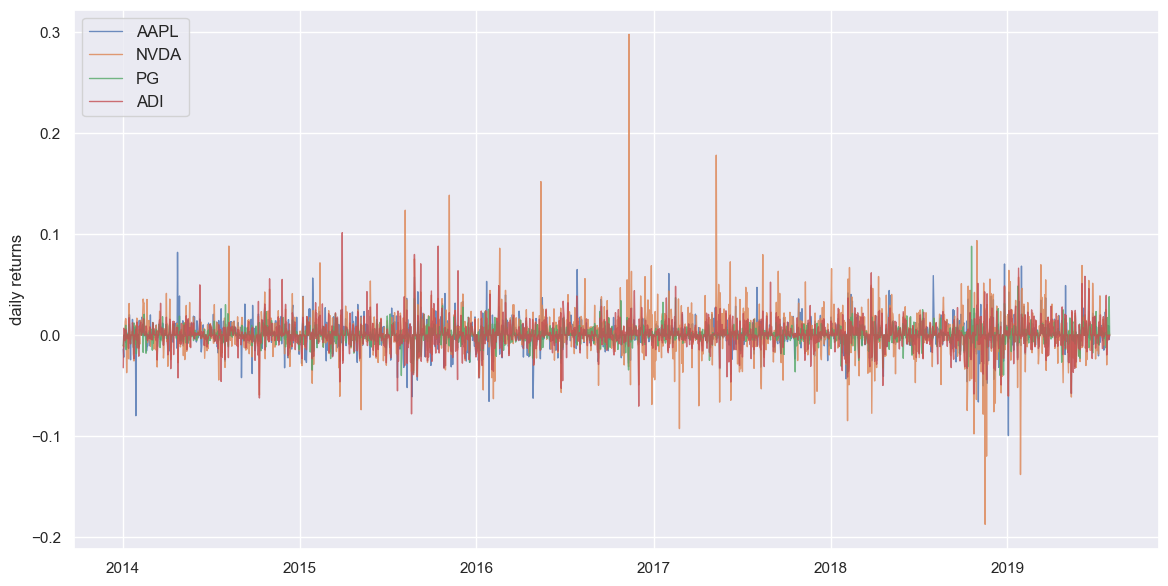

In [186]:
stocks = by_date[['AAPL', 'NVDA', 'PG', 'ADI']]
selectedreturns = stocks.pct_change()

plt.figure(figsize=(14,7))
for c in selectedreturns.columns.values:
    plt.plot(selectedreturns.index, selectedreturns[c], lw = 1, alpha = 0.8, label = c)
plt.legend(loc= 'upper left', fontsize = 12)
plt.ylabel('daily returns')


In [188]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights)*252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [198]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(4)
        weights /= np.sum(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
        weights_record.append(weights)
    
    return results, weights_record   

In [200]:
#inputs for variables 
inputreturns = selectedreturns
mean_returns = inputreturns.mean()
cov_matrix = inputreturns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178

In [202]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate)

    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0, max_sharpe_idx], results[1, max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx], index=inputreturns.columns, columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100, 2) for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0, min_vol_idx], results[1, min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx], index=inputreturns.columns, columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100, 2) for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T

    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp, 2))
    print("Annualised Volatility:", round(sdp, 2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min, 2))
    print("Annualised Volatility:", round(sdp_min, 2))
    print("\n")
    print(min_vol_allocation)

    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp, rp, marker='*', color='r', s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min, rp_min, marker='*', color='g', s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.21
Annualised Volatility: 0.18


Symbol       AAPL  NVDA     PG   ADI
allocation  19.53  43.6  36.19  0.69
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.09
Annualised Volatility: 0.11


Symbol      AAPL  NVDA     PG   ADI
allocation  15.1  0.52  75.26  9.11


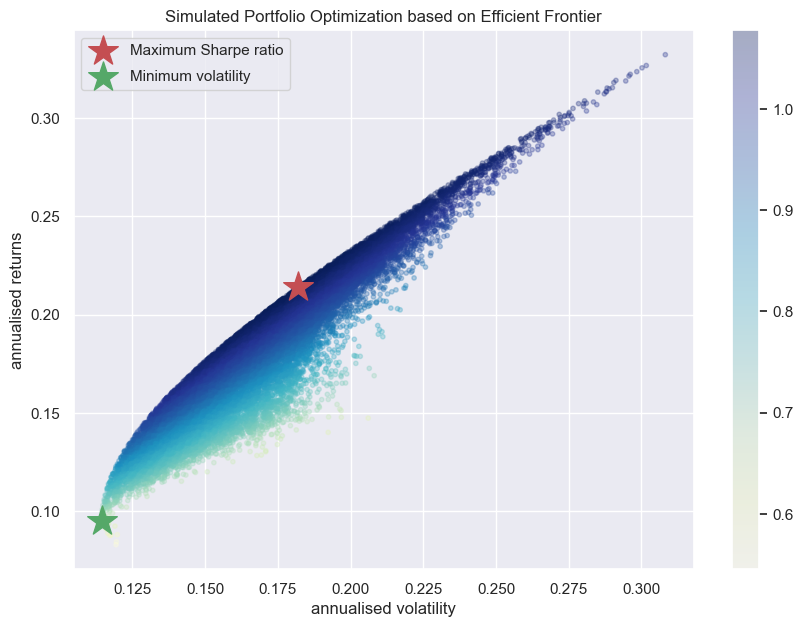

In [204]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)